In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('dataset/in_and_out.csv', encoding='cp949')
data

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
0,202504,1호선,동대문,650,26,11355,2005,10238,7181,18411,...,9939,938,3210,3,321,0,0,0,0,20250503
1,202504,1호선,동묘앞,117,3,2844,819,4206,5444,9689,...,4897,120,1996,3,267,0,0,0,0,20250503
2,202504,1호선,서울역,712,48,10654,9668,29272,64058,97455,...,29252,5212,8018,10,262,0,0,0,0,20250503
3,202504,1호선,시청,124,5,2267,5900,3888,28761,7841,...,3763,606,1015,0,15,0,0,0,0,20250503
4,202504,1호선,신설동,381,18,9393,2330,10420,9020,24157,...,9416,455,3039,0,0,1,2,0,0,20250503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14857,202305,중앙선,원덕,95,0,394,6,740,182,885,...,328,3,80,0,0,0,0,0,0,20230603
14858,202305,중앙선,중랑,153,5,6886,593,10126,2329,24074,...,5311,34,486,0,0,0,0,0,0,20230603
14859,202305,중앙선,지평,0,0,0,0,4,2,384,...,0,0,0,0,0,0,0,0,0,20230603
14860,202305,중앙선,팔당,0,0,259,78,726,728,1658,...,202,0,0,0,0,0,0,0,0,20230603


C:\Users\kkh02\AppData\Local\Temp\ipykernel_9748\850459830.py:20: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kkh02\AppData\Local\Temp\ipykernel_9748\850459830.py:20: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kkh02\AppData\Local\Temp\ipykernel_9748\850459830.py:20: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kkh02\AppData\Local\Temp\ipykernel_9748\850459830.py:20: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kkh02\AppData\Local\Temp\ipykernel_9748\850459830.py:20: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\kkh02\llll\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from f

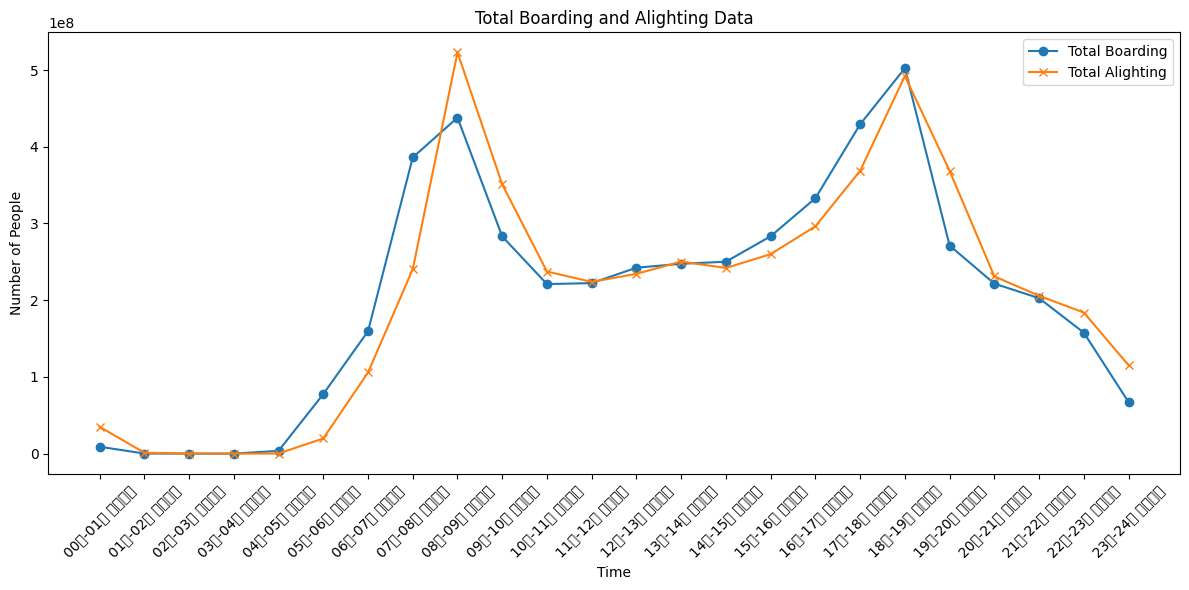

In [18]:
boarding_cols = [col for col in data.columns if '승차인원' in col]
alighting_cols = [col for col in data.columns if '하차인원' in col]

boarding_data = data[boarding_cols].sum(axis=1)
alighting_data = data[alighting_cols].sum(axis=1)

grouped = data.groupby('사용월')

grouped_boarding = grouped[boarding_cols].sum()
grouped_alighting = grouped[alighting_cols].sum()

plt.figure(figsize=(12, 6))
plt.plot(boarding_cols, data[boarding_cols].sum(), label='Total Boarding', marker='o')
plt.plot(boarding_cols, data[alighting_cols].sum(), label='Total Alighting', marker='x')  # x축을 boarding_cols로 통일
plt.title('Total Boarding and Alighting Data')
plt.xlabel('Time')
plt.ylabel('Number of People')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
from sklearn.model_selection import train_test_split

# 시간대별 컬럼 정렬 (LSTM 코드와 동일)
time_cols = [col for col in data.columns if '승차' in col or '하차' in col]
time_order = sorted(set(col.split()[0] for col in time_cols), key=lambda x: int(x[:2])*60+int(x[3:5]))
ordered_cols = []
for t in time_order:
    ordered_cols.append(f'{t} 승차인원')
    ordered_cols.append(f'{t} 하차인원')
data = data[['사용월', '호선명', '지하철역'] + ordered_cols]

# 월 기준 훈련/테스트 분할
train = data[data['사용월'] < 202501]
test = data[data['사용월'] >= 202501]

# 머신러닝 입력/출력 데이터 생성 (슬라이딩 윈도우 방식)
def make_ml_data(df, window_size=3, target_offset=1):
    X, y = [], []
    arr = df[ordered_cols].values
    for i in range(len(arr) - window_size - target_offset + 1):
        X.append(arr[i:i+window_size].flatten())
        y.append(arr[i+window_size+target_offset-1][:2])  # 예: 다음 시간대 승차/하차
    return np.array(X), np.array(y)

X_train, y_train = make_ml_data(train)
X_test, y_test = make_ml_data(test)


In [9]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 모델 정의
models = {
    'XGBoost': XGBRegressor(tree_method='hist', n_jobs=-1, random_state=42),
    'LightGBM': LGBMRegressor(n_jobs=-1, random_state=42),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=200, batch_size=256, random_state=42)
}

results = {}

for name, base_model in models.items():
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f'{name} - MSE: {mse:.2f}, R2: {r2:.2f}')

# 결과 출력
print('\n[모델별 성능 요약]')
for name, res in results.items():
    print(f'{name}: MSE={res["MSE"]:.2f}, R2={res["R2"]:.2f}')


XGBoost - MSE: 421707.94, R2: 0.89
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32731
[LightGBM] [Info] Number of data points in the train set: 12376, number of used features: 141
[LightGBM] [Info] Start training from score 605.288866
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32731
[LightGBM] [Info] Number of data points in the train set: 12376, number of used features: 141
[LightGBM] [Info] Start training from score 2375.039189


c:\Users\kkh02\llll\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\kkh02\llll\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM - MSE: 337098.02, R2: 0.92
MLPRegressor - MSE: 548543.09, R2: 0.83

[모델별 성능 요약]
XGBoost: MSE=421707.94, R2=0.89
LightGBM: MSE=337098.02, R2=0.92
MLPRegressor: MSE=548543.09, R2=0.83


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 시간대 컬럼 정렬
time_cols = [col for col in data.columns if '승차' in col or '하차' in col]
time_order = sorted(set(col.split()[0] for col in time_cols), 
                   key=lambda x: int(x[:2])*60 + int(x[3:5]))
ordered_cols = []
for t in time_order:
    ordered_cols.append(f'{t} 승차인원')
    ordered_cols.append(f'{t} 하차인원')
data = data[['사용월', '호선명', '지하철역'] + ordered_cols]

# 2. 훈련/테스트 분할
train = data[data['사용월'] < 202501]
test = data[data['사용월'] >= 202501]

# 3. 입력/출력 데이터 생성
def make_ml_data(df, window_size=3):
    X, y = [], []
    arr = df[ordered_cols].values
    for i in range(len(arr) - window_size):
        X.append(arr[i:i+window_size].flatten())  # 3시간 데이터 평탄화
        y.append(arr[i+window_size][:2])          # 다음 시간대 승차+하차
    return np.array(X), np.array(y)

X_train, y_train = make_ml_data(train)
X_test, y_test = make_ml_data(test)

# 4. 데이터 스케일링 (X만 수행)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# 5. 모델 정의 및 학습
models = {
    'DecisionTree': MultiOutputRegressor(DecisionTreeRegressor(random_state=42)),
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_estimators=20, random_state=42)),
    'XGBoost': MultiOutputRegressor(XGBRegressor(tree_method='hist', n_jobs=-1)),
    'LightGBM': MultiOutputRegressor(LGBMRegressor(n_jobs=-1)),
    'MLP': MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(128,64), max_iter=200))
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'R2': r2}
    print(f'{name} - MSE: {mse:.2f}, R2: {r2:.2f}')

# 6. 결과 비교
print("\n최종 성능 비교:")
for model, scores in results.items():
    print(f"{model:15} | MSE: {scores['MSE']:.1f} | R²: {scores['R2']:.2f}")


DecisionTree - MSE: 893194.65, R2: 0.74
RandomForest - MSE: 269878.27, R2: 0.92
XGBoost - MSE: 421707.94, R2: 0.89
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32746
[LightGBM] [Info] Number of data points in the train set: 12376, number of used features: 141
[LightGBM] [Info] Start training from score 605.288866
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32746
[LightGBM] [Info] Number of data points in the train set: 12376, number of used features: 141
[LightGBM] [Info] Start training from score 2375.039189


c:\Users\kkh02\llll\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\kkh02\llll\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM - MSE: 364106.40, R2: 0.90


c:\Users\kkh02\llll\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP - MSE: 343841.56, R2: 0.91

최종 성능 비교:
DecisionTree    | MSE: 893194.6 | R²: 0.74
RandomForest    | MSE: 269878.3 | R²: 0.92
XGBoost         | MSE: 421707.9 | R²: 0.89
LightGBM        | MSE: 364106.4 | R²: 0.90
MLP             | MSE: 343841.6 | R²: 0.91


c:\Users\kkh02\llll\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


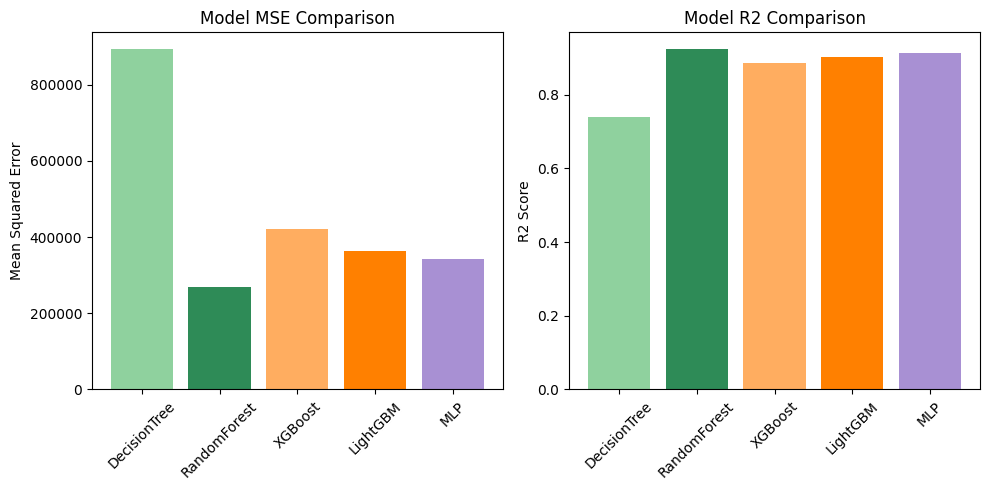

In [ ]:
import matplotlib.pyplot as plt


model_colors = {
    'DecisionTree': '#8fd19e',   
    'RandomForest': '#2e8b57',    
    'XGBoost': '#ffad60',        
    'LightGBM': '#ff8000',        
    'MLP': '#a890d3'             
}
colors = [model_colors[m] for m in models]

plt.figure(figsize=(10, 5))

# MSE 바 차트
plt.subplot(1, 2, 1)
plt.bar(models, mse_values, color=colors)
plt.title('Model MSE Comparison')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)

# R2 바 차트
plt.subplot(1, 2, 2)
plt.bar(models, r2_values, color=colors)
plt.title('Model R2 Comparison')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
